# Note:
This file is what I used for *preparing* the exam; you would not get to see it while *taking* the exam. The exam is purely pen and paper, based on the provided PDF file.

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as tsa
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from arch.univariate import arch_model

# Question 1

In [2]:
df = pd.read_excel("ar2.xlsx", header=None, names=["y"])

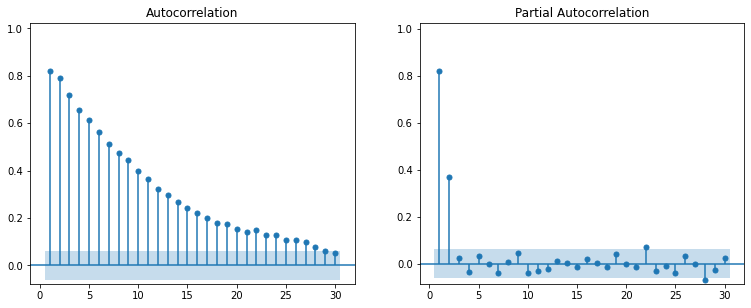

In [3]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.8, 4.8))
sm.graphics.tsa.plot_acf(df.y, ax=ax1, bartlett_confint=False, zero=False, auto_ylims=True)
sm.graphics.tsa.plot_pacf(df.y, ax=ax2, zero=False, auto_ylims=True, method="ols-inefficient");
fig.savefig("correlogram_ar2.pdf")

In [4]:
1.96 / np.sqrt(1000)

0.061980642139300234

In [5]:
ADF, p, crits, res = tsa.stattools.adfuller(df.y, regression='c', autolag='AIC', store=True)
print(res.resols.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.208
Model:                            OLS   Adj. R-squared:                  0.207
Method:                 Least Squares   F-statistic:                     130.9
Date:                Tue, 17 Oct 2023   Prob (F-statistic):           3.47e-51
Time:                        16:31:10   Log-Likelihood:                -2086.9
No. Observations:                 998   AIC:                             4180.
Df Residuals:                     995   BIC:                             4195.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1161      0.018     -6.520      0.0

In [6]:
mod = ARIMA(df.y, order=(2, 0, 0)).fit()
print(mod.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1000
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -2091.958
Date:                Tue, 17 Oct 2023   AIC                           4191.917
Time:                        16:31:11   BIC                           4211.548
Sample:                             0   HQIC                          4199.378
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2158      0.528      0.409      0.683      -0.818       1.250
ar.L1          0.5236      0.032     16.396      0.000       0.461       0.586
ar.L2          0.3595      0.032     11.326      0.0

In [7]:
mod.predict(1000) # same as 0.2158 * (1 - 0.5236 - 0.3595) + 0.5236 * (-0.75) + 0.3595 * (-0.77) up to rounding error

1000   -0.645154
dtype: float64

# Question 2

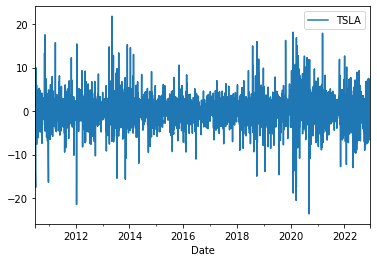

In [8]:
df = pd.read_csv("TSLA.csv", index_col="Date")
df.index = pd.DatetimeIndex(df.index, dayfirst=True).to_period('D')
df["r"] = np.log(df.TSLA).diff() * 100
df.columns = ["price", "TSLA"]
df.dropna(inplace=True)
df.TSLA.plot()
plt.legend()
plt.savefig("tsla.pdf")

In [9]:
model = arch_model(df.TSLA, mean='Constant', vol='GARCH', p=1, q=1).fit(disp=None)
print(model.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   TSLA   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -8267.70
Distribution:                  Normal   AIC:                           16543.4
Method:            Maximum Likelihood   BIC:                           16567.6
                                        No. Observations:                 3138
Date:                Tue, Oct 17 2023   Df Residuals:                     3137
Time:                        16:31:11   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.1118  5.774e-02      1.936  5.281e-02 [-1.35

In [10]:
*rest, res = sm.stats.diagnostic.het_arch(model.std_resid, nlags=5, store=True)
print(*rest, res.resols.rsquared)

11.409842922458935 0.04383301199119564 2.2859233290209486 0.043757885360774816 0.003641826658939973


In [11]:
model.resid.tail(1)

Date
2022-12-14   -2.724078
Freq: D, Name: resid, dtype: float64

In [12]:
(model.conditional_volatility ** 2).tail(1)

Date
2022-12-14    15.19764
Freq: D, Name: cond_vol, dtype: float64

In [13]:
model.forecast(reindex=False).variance

,h.1
Date,
2022-12-14,14.914865


# Question 3

In [14]:
fore = model.forecast(reindex=False)
mu = fore.mean
sigma = np.sqrt(fore.variance)

In [15]:
-mu - sigma * model.model.distribution.ppf(0.01)

,h.1
Date,
2022-12-14,8.872485


In [16]:
df["VaRs"] = (-fore.mean["h.1"].values - model.conditional_volatility *  model.model.distribution.ppf(0.01)).to_frame()

In [17]:
df["I"] = (-df.TSLA > df.VaRs).astype(int)
df["b0"] = 1

In [18]:
res = smf.ols(formula = "np.subtract(I, 0.01) ~ 0 + b0 + I.shift(1) ", data=df).fit()
print(res.summary())

                             OLS Regression Results                             
Dep. Variable:     np.subtract(I, 0.01)   R-squared:                       0.000
Model:                              OLS   Adj. R-squared:                  0.000
Method:                   Least Squares   F-statistic:                     1.409
Date:                  Tue, 17 Oct 2023   Prob (F-statistic):              0.235
Time:                          16:31:11   Log-Likelihood:                 1976.8
No. Observations:                  3137   AIC:                            -3950.
Df Residuals:                      3135   BIC:                            -3938.
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
b0             0.0065      0.002